# Auto HPO from scratch using TPE

In [1]:
# Loading the data
import pandas as pd
df = pd.read_csv(r"C:\Users\Abuba\Downloads\The_Cancer_data_1500_V2.csv")
Y = df['Diagnosis']
X = df.drop(columns=df.columns[-1])
X

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory
0,58,1,16.085313,0,1,8.146251,4.148219,1
1,71,0,30.828784,0,1,9.361630,3.519683,0
2,48,1,38.785084,0,2,5.135179,4.728368,0
3,34,0,30.040296,0,0,9.502792,2.044636,0
4,62,1,35.479721,0,0,5.356890,3.309849,0
...,...,...,...,...,...,...,...,...
1495,62,1,25.090025,0,0,9.892167,1.284158,0
1496,31,0,33.447125,0,1,1.668297,2.280636,1
1497,63,1,32.613861,1,1,0.466848,0.150101,0
1498,55,0,25.568216,0,0,7.795317,1.986138,1


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state = 42)

In [3]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import random 
import warnings
from sklearn.preprocessing import LabelEncoder


In [4]:
space = {
    'svm': {
        'model': svm.SVC(gamma = 'auto', probability = True),
        'params': {
            'C': [0.1, 0.5, 1, 5, 10],
            'kernel': ['rbf', 'linear', 'sigmoid'],
            'gamma': ['scale', 'auto'],
            'degree': [2, 3, 4, 5]
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            'max_depth': [5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [4, 8, 12]
    }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver = 'liblinear',multi_class='ovr'),
        'params': {
            'C' : [0.1, 0.5, 1, 5, 10],
            'penalty': ['l1', 'l2'],
            'max_iter': [100, 500, 1000]
        }
    }
}

In [5]:
def custom_cross_val_auc(model, X, y, cv_splits=5):
    cv = StratifiedKFold(n_splits=cv_splits)
    auc_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train_cv, y_train_cv)
        y_prob = model.predict_proba(X_val_cv)[:, 1]  # Probability of positive class

        auc = roc_auc_score(y_val_cv, y_prob)
        auc_scores.append(auc)

    return np.array(auc_scores)
def objective_function(config, algo, X_train, Y_train):
    model = space[algo]['model']
    model.set_params(**config)
    auc_scores = custom_cross_val_auc(model, X_train, Y_train, cv_splits=5)
    mean_auc_score = np.mean(auc_scores)
    return mean_auc_score

In [6]:
observations = []

algorithms = list(space.keys())

for i in range(15):
    print(f"Trial: {i+1}/15")
    algo = random.choice(algorithms)
    if algo == 'svm':
        hyperparams = {
            'model': svm.SVC(gamma = 'auto', probability=True),
            'params': {
                'C': random.choice(space[algo]['params']['C']),
                'kernel': random.choice(space[algo]['params']['kernel']),
                'gamma': random.choice(space[algo]['params']['gamma']),
                'degree': np.random.choice(space[algo]['params']['degree'])
            }
        }
    elif algo == 'random_forest':
        hyperparams = {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': random.choice(space[algo]['params']['n_estimators']),
                'max_depth': (random.choice(space[algo]['params']['max_depth'])),
                'min_samples_split': random.choice(space[algo]['params']['min_samples_split']),
                'min_samples_leaf': random.choice(space[algo]['params']['min_samples_leaf'])
                }
            }
    elif algo == 'logistic_regression':
        hyperparams = {
        'model': LogisticRegression(solver = 'liblinear'),
        'params': {
            'C' : random.choice(space[algo]['params']['C']),
            'penalty': random.choice(space[algo]['params']['penalty']),
            'max_iter': random.choice(space[algo]['params']['max_iter'])
            }
        }
    #print(hyperparams)
    score = objective_function(hyperparams['params'], algo, X_train, Y_train)
    observations.append((hyperparams, score))

Trial: 1/15
Trial: 2/15
Trial: 3/15
Trial: 4/15
Trial: 5/15
Trial: 6/15
Trial: 7/15
Trial: 8/15
Trial: 9/15
Trial: 10/15
Trial: 11/15
Trial: 12/15
Trial: 13/15
Trial: 14/15
Trial: 15/15


In [7]:
observations

[({'model': RandomForestClassifier(),
   'params': {'n_estimators': 60,
    'max_depth': 20,
    'min_samples_split': 2,
    'min_samples_leaf': 8}},
  0.9422182504340897),
 ({'model': RandomForestClassifier(),
   'params': {'n_estimators': 70,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 12}},
  0.9424507559142835),
 ({'model': RandomForestClassifier(),
   'params': {'n_estimators': 100,
    'max_depth': 20,
    'min_samples_split': 5,
    'min_samples_leaf': 4}},
  0.9446596792488904),
 ({'model': RandomForestClassifier(),
   'params': {'n_estimators': 5,
    'max_depth': 20,
    'min_samples_split': 2,
    'min_samples_leaf': 8}},
  0.9261211249902537),
 ({'model': RandomForestClassifier(),
   'params': {'n_estimators': 40,
    'max_depth': 20,
    'min_samples_split': 2,
    'min_samples_leaf': 8}},
  0.940247369960883),
 ({'model': LogisticRegression(solver='liblinear'),
   'params': {'C': 10, 'penalty': 'l2', 'max_iter': 100}},
  0.9088398833680879),
 

In [8]:
hyperparameter_ranges = {
    'svm': {
        'C': (0.001, 1000),
        'degree': (1, 5)
    },
    'random_forest': {
        'n_estimators': (1, 1000),
        'max_depth': (1, 50),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 20)
    },
    'logistic_regression': {
        'C': (0.001, 1000),
        'max_iter': (50, 300)
    }
}

label_encoders = {
    'svm': {
        'C': None,
        'kernel': LabelEncoder().fit(['rbf', 'linear', 'sigmoid']),
        'gamma': LabelEncoder().fit(['scale', 'auto']),
        'degree': None
    },
    'random_forest': {
        'n_estimators': None,
        'max_depth': None,
        'min_samples_split': None,
        'min_samples_leaf': None
    },
    'logistic_regression': {
        'C': None,
        'penalty': LabelEncoder().fit(['l1', 'l2']),
        'max_iter': None
    }
}

model_name_to_space_key = {
        'svc': 'svm',
        'randomforestclassifier': 'random_forest',
        'logisticregression': 'logistic_regression'
    }

In [9]:
'''The most difficult of the part was to handle the categorical hyperparameters because .fit() method of kernel density accepts 
   only 2D array of numerical values. 
   So I had to encode them to numerical values.
'''

def encode_hyperparameters(algo_name, hyperparams):
    encoded = []
    for param_name, param_value in hyperparams.items():
        if label_encoders[algo_name][param_name] is not None:  
            le = label_encoders[algo_name][param_name]
            encoded.append(le.transform([param_value])[0])
        else:
            encoded.append(param_value)
    return encoded

def clip_hyperparameters(hyperparams, algo_name):
    clipped_hyperparams = {}
    for param, value in hyperparams.items():
        if param in hyperparameter_ranges[algo_name]:
            min_val, max_val = hyperparameter_ranges[algo_name][param]
            clipped_hyperparams[param] = np.clip(value, min_val, max_val)
        else:
            clipped_hyperparams[param] = value
    return clipped_hyperparams

def fit_kde(X):
        if len(X) < 2:
            return None
        kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(X)
        return kde
    
def decode_hyperparameters(encoded_hyperparams, algo_name):
    decoded_hyperparams = {}
    index = 0
    for param_name in space[algo_name]['params']:
        if label_encoders[algo_name][param_name] is not None:  # Categorical parameter
            le = label_encoders[algo_name][param_name]
            decoded_value = le.inverse_transform([int(round(encoded_hyperparams[index]))])[0]
            decoded_hyperparams[param_name] = decoded_value
            index += 1
        else:
            decoded_hyperparams[param_name] = int(round(encoded_hyperparams[index]))
            index += 1
    return decoded_hyperparams

def infer_algo_name(encoded_hyperparams):
    for algo_name, params_dict in label_encoders.items():
        expected_length = sum(len(le.classes_) if le is not None else 1 for le in params_dict.values())
        if len(encoded_hyperparams) == expected_length:
            return algo_name
    return None

In [10]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KernelDensity
import warnings

warnings.filterwarnings('ignore')

best_score = 0
best_config = None
curve = []
for i in range(50):
    print(f"Trial: {i + 1}/50")
    encoded_observations = []
    for obs in observations:
        hyperparams, score = obs
        model_class_name = hyperparams['model'].__class__.__name__.lower()
        algo_name = model_name_to_space_key[model_class_name]
        encoded_hyperparams = encode_hyperparameters(algo_name, hyperparams['params'])
        encoded_observations.append(encoded_hyperparams + [score])

    max_length = max(len(obs) for obs in encoded_observations)
    padded_observations = np.array([obs + [0] * (max_length - len(obs)) for obs in encoded_observations])

    sorted_observations = sorted(padded_observations, key=lambda x: x[-1], reverse=True)
    split_index = int(len(sorted_observations) * 0.2)
    if split_index == 0:
        split_index = 1

    X1 = np.array(sorted_observations[:split_index])
    X2 = np.array(sorted_observations[split_index:])
    if X1.ndim == 1:
        X1 = X1.reshape(1, -1)
    if X2.ndim == 1:
        X2 = X2.reshape(1, -1)
    if len(X1) == 0:
        X1 = np.array([sorted_observations[0]])
    if len(X2) == 0:
        X2 = np.array([sorted_observations[-1]])

    scaler = StandardScaler()
    X1_normalized = scaler.fit_transform(X1)
    X2_normalized = scaler.transform(X2)

    kde_x1 = fit_kde(X1_normalized)
    kde_x2 = fit_kde(X2_normalized)

    if kde_x1:
        sample_hyperparameters_normalized = kde_x1.sample(10)
        sample_hyperparameters = scaler.inverse_transform(sample_hyperparameters_normalized)
    else:
        sample_hyperparameters = X1  

    if kde_x1 and kde_x2:
        log_prob_x1 = kde_x1.score_samples(sample_hyperparameters_normalized)
        log_prob_x2 = kde_x2.score_samples(sample_hyperparameters_normalized)
        log_ratio = log_prob_x1 - log_prob_x2
        ratio = np.exp(log_ratio)
    else:
        ratio = np.zeros(len(sample_hyperparameters))  # Fallback ratio

    best_hyperparameters = sample_hyperparameters[np.argmin(ratio)]

    encoded_hyperparams_without_score = best_hyperparameters[:-1]
    inferred_algo_name = infer_algo_name(encoded_hyperparams_without_score)
    if inferred_algo_name is None:
        raise ValueError("Unable to infer the algorithm from the encoded hyperparameters.")

    decoded_hyperparams = decode_hyperparameters(encoded_hyperparams_without_score, inferred_algo_name)
    decoded_hyperparams = clip_hyperparameters(decoded_hyperparams, inferred_algo_name)

    # Append new observation
    if inferred_algo_name == 'svm':
        model_instance = SVC(probability=True)
    elif inferred_algo_name == 'random_forest':
        model_instance = RandomForestClassifier()
    elif inferred_algo_name == 'logistic_regression':
        model_instance = LogisticRegression(solver='liblinear')
    else:
        raise ValueError(f"Unknown algorithm '{inferred_algo_name}'")

    observations.append(({"model": model_instance, "params": decoded_hyperparams}, best_hyperparameters[-1]))
    curve.append((i + 1, best_hyperparameters[-1]))
    if best_score < best_hyperparameters[-1]:
        best_config = decoded_hyperparams
        best_score = best_hyperparameters[-1]
    print(best_hyperparameters[-1])
    print(best_score)


Trial: 1/50
0.9418831134691138
0.9418831134691138
Trial: 2/50
0.9428627268089755
0.9428627268089755
Trial: 3/50
0.9444307930910584
0.9444307930910584
Trial: 4/50
0.943441321190333
0.9444307930910584
Trial: 5/50
0.9429133814892571
0.9444307930910584
Trial: 6/50
0.9435539811619278
0.9444307930910584
Trial: 7/50
0.9426814979556943
0.9444307930910584
Trial: 8/50
0.9429046847565814
0.9444307930910584
Trial: 9/50
0.9429155768877909
0.9444307930910584
Trial: 10/50
0.9431418139504403
0.9444307930910584
Trial: 11/50
0.9435092534370354
0.9444307930910584
Trial: 12/50
0.9438862934062078
0.9444307930910584
Trial: 13/50
0.9437720411747216
0.9444307930910584
Trial: 14/50
0.9433145263135193
0.9444307930910584
Trial: 15/50
0.9437950175757773
0.9444307930910584
Trial: 16/50
0.943498389074356
0.9444307930910584
Trial: 17/50
0.9436007342281416
0.9444307930910584
Trial: 18/50
0.9430708278029537
0.9444307930910584
Trial: 19/50
0.9432821427643032
0.9444307930910584
Trial: 20/50
0.9433028887242128
0.94443079

## Plot of ROC AUC Score vs trial number

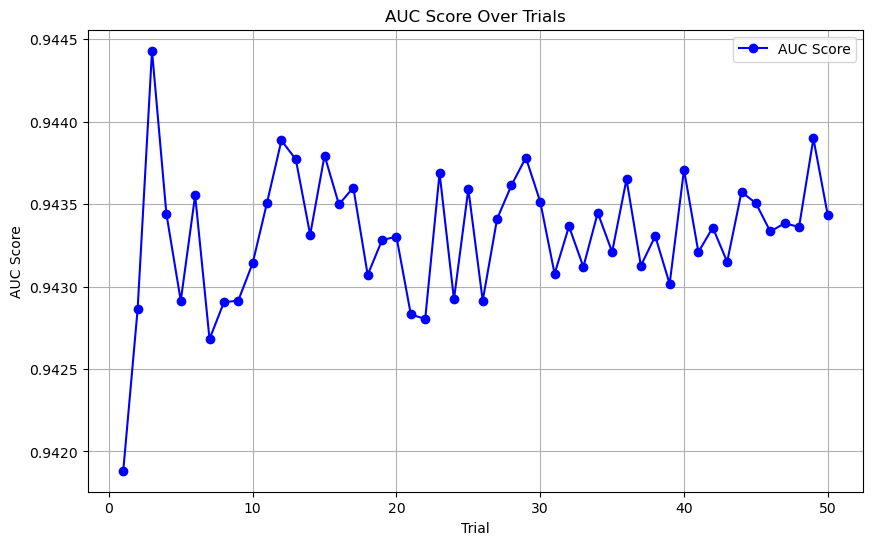

In [11]:
import matplotlib.pyplot as plt

# Separate the curve into two lists: x values and y values
x_values, y_values = zip(*curve)

# Plotting the curve
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', label='AUC Score')
plt.xlabel('Trial')
plt.ylabel('AUC Score')
plt.title('AUC Score Over Trials')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
print(best_score)
best_config 

0.9444307930910584


{'n_estimators': 68,
 'max_depth': 11,
 'min_samples_split': 4,
 'min_samples_leaf': 8}

## Hyperparameter Optimization using Hyperopt

In [13]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

In [14]:
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

space = {
    'random_forest': {
        'type': 'random_forest',
    'criterion': hp.choice('criterion', ['entropy', 'gini']),
    'n_estimators': hp.quniform("n_estimators", 100, 600, 50), 
    'max_depth': hp.quniform('max_depth', 10, 1200, 10),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),  
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
    },
    'svm': {
        'type': 'svm',
        'C': hp.uniform('C', 0.1, 10),
        'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'rbf']),
        'degree': hp.choice('degree', [2, 3, 4])
    },
    'logistic_regression': {
        'type': 'logistic_regression',
        'penalty': hp.choice('penalty', ['l1', 'l2']),
        'C': hp.loguniform('C', np.log(1e-5), np.log(100)),
        'max_iter': hp.choice('max_iter', [100, 500, 1000])
    }
}

def objective(params):
    model_type = params.pop('type')
    
    if model_type == 'random_forest':
        params['max_depth'] = int(params['max_depth'])
        params['min_samples_split'] = int(params['min_samples_split'])
        params['min_samples_leaf'] = int(params['min_samples_leaf'])
        params['n_estimators'] = int(params['n_estimators'])
        model = RandomForestClassifier(**params)
    elif model_type == 'svm':
        model = SVC(gamma='auto', probability=True, **params)
    elif model_type == 'logistic_regression':
        model = LogisticRegression(solver='liblinear', multi_class='ovr', **params)
    
    roc_auc = cross_val_score(model, X_train, Y_train, scoring='roc_auc', cv=4).mean()
    return {'loss': -roc_auc, 'status': STATUS_OK}

for model_name, model_space in space.items():
    trials = Trials()
    best = fmin(fn=objective,
                space=model_space,
                algo=tpe.suggest,
                max_evals=15,
                trials=trials)
    print(f"Best parameters for {model_name}: {best}")


100%|███████████████████████████████████████████████████████████████████| 15/15 [01:49<00:00,  7.29s/trial, best loss: -0.945104061683009]
Best parameters for random_forest: {'criterion': 0, 'max_depth': 350.0, 'min_samples_leaf': 5.0, 'min_samples_split': 8.0, 'n_estimators': 600.0}
100%|██████████████████████████████████████████████████████████████████| 15/15 [00:20<00:00,  1.38s/trial, best loss: -0.9084401558085768]
Best parameters for svm: {'C': 1.4352430876088755, 'degree': 1, 'kernel': 0}
100%|██████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.33trial/s, best loss: -0.9086792551266235]
Best parameters for logistic_regression: {'C': 10.850479121585362, 'max_iter': 2, 'penalty': 0}


### The best model is random forest in both cases 

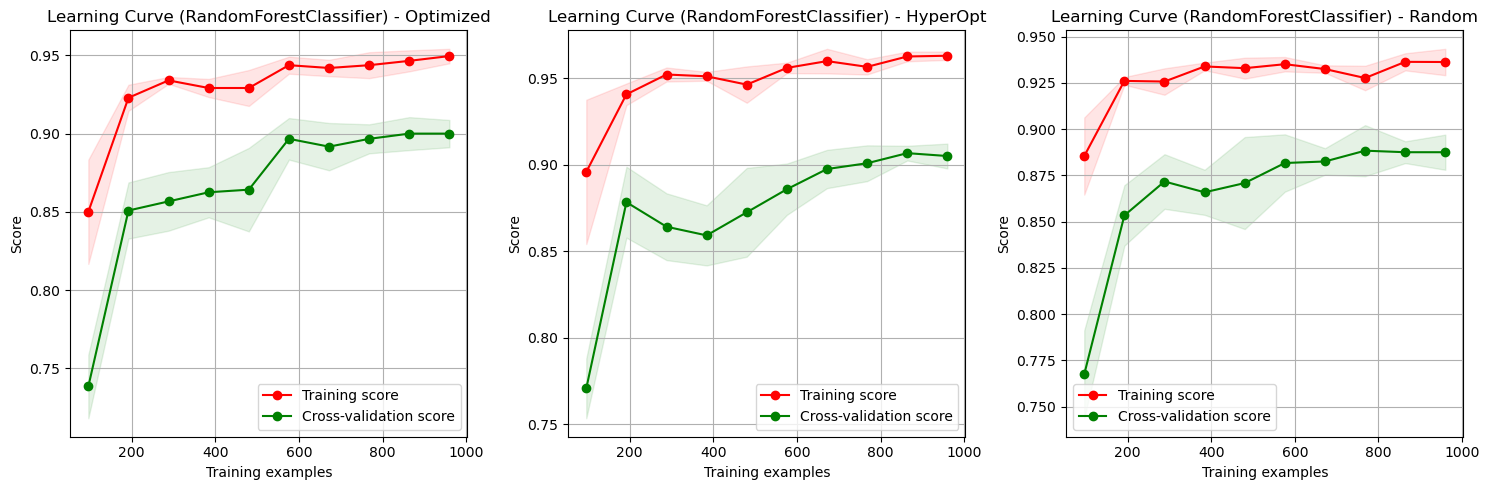

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.datasets import load_iris

estimator_Optimized = RandomForestClassifier(
    n_estimators=68, 
    max_depth=11,
    min_samples_leaf=8,
    min_samples_split=4,
    random_state=42
)
estimator_HyperOpt = RandomForestClassifier(
    n_estimators=600, 
    max_depth=350,
    min_samples_leaf=5,
    min_samples_split=8,
    random_state=42
)
estimator_Random = RandomForestClassifier(
    n_estimators=40, 
    max_depth=6,
    min_samples_leaf=6,
    min_samples_split=8,
    random_state=42
)
estimators = {
    "Optimized": estimator_Optimized,
    "HyperOpt": estimator_HyperOpt,
    "Random": estimator_Random
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

for label, estimator in estimators.items():
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, Y_train, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.subplot(1, len(estimators), list(estimators.keys()).index(label) + 1)
    plt.title(f"Learning Curve (RandomForestClassifier) - {label}")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

plt.tight_layout()
plt.show()
